In [9]:
!pip install anomalib
!pip install lightning kornia torchmetrics torch FrEIA python-dotenv open-clip-torch
!pip install qdrant-client
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import Patchcore, EfficientAd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from tqdm.notebook import tqdm
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
from PIL import Image
import torchvision.transforms as T

In [23]:
class AnomalySimSearch:
    def __init__(self, model, category):
        self.model = model
        self.category = category
        self.client = QdrantClient(":memory:")

        self.client.create_collection(
            collection_name=category,
            vectors_config=VectorParams(
                size=512,
                distance=Distance.COSINE
            )
        )

    def extract_features(self, images):
        """Extract features from images."""
        self.model.eval()
        device = next(self.model.parameters()).device

        with torch.no_grad():
            # Handle input
            if isinstance(images, dict):
                input_tensor = images['image'].to(device)
            else:
                input_tensor = images.to(device)

            # Get predictions and use anomaly maps as features
            _ = self.model(input_tensor)
            features = self.model.anomaly_map(input_tensor)

            # Reshape features
            if len(features.shape) > 2:
                features = features.reshape(features.shape[0], -1)

            return features.cpu().numpy()

    def index_dataset(self, datamodule):
        """Index test dataset images."""
        print(f"Indexing images for {self.category}...")
        test_loader = datamodule.test_dataloader()
        device = next(self.model.parameters()).device

        for batch_idx, batch in enumerate(tqdm(test_loader)):

            if isinstance(batch, dict):
                images = batch['image']
                labels = batch.get('label', torch.zeros(len(images)))
            elif isinstance(batch, (tuple, list)):
                images = batch[0]
                labels = batch[1] if len(batch) > 1 else torch.zeros(len(batch[0]))
            else:
                images = batch
                labels = torch.zeros(len(images))

            #  predictions and features
            images = images.to(device)
            with torch.no_grad():
                predictions = self.model(images)
                features = self.extract_features({'image': images})

            # Store features
            for idx, (feature, label) in enumerate(zip(features, labels)):
                score = float(predictions[idx].cpu().item())
                self.client.upsert(
                    collection_name=self.category,
                    points=[PointStruct(
                        id=batch_idx * len(images) + idx,
                        payload={
                            "is_anomaly": bool(label.item()),
                            "anomaly_score": score
                        },
                        vector=feature.tolist()
                    )]
                )

    def find_similar(self, images, top_k=5):
        """Find similar images."""
        if isinstance(images, dict):
            features = self.extract_features(images)
        else:
            features = self.extract_features({'image': images})

        results = self.client.search(
            collection_name=self.category,
            query_vector=features[0].tolist(),
            limit=top_k
        )

        return results

    def visualize_similar(self, images, top_k=5):
        """Visualize query image and similar matches."""
        similar = self.find_similar(images, top_k)

        if isinstance(images, dict):
            query_image = images['image']
        else:
            query_image = images

        plt.figure(figsize=(15, 3))

        # Query image
        plt.subplot(1, top_k + 1, 1)
        plt.imshow(query_image.cpu().permute(1, 2, 0))
        plt.title('Query Image')
        plt.axis('off')

        # Similar images
        for i, hit in enumerate(similar, 1):
            plt.subplot(1, top_k + 1, i + 1)
            plt.imshow(query_image.cpu().permute(1, 2, 0))
            plt.title(f'Similar {i}\nScore: {hit.payload["anomaly_score"]:.3f}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        return similar

In [12]:
def train_and_evaluate(category, model_class=EfficientAd):
    """Train and evaluate a model on a specific category."""
    print(f"Training {model_class.__name__} on {category}")

    batch_size = 1
    datamodule = MVTec(
        root="./datasets/MVTec",
        category=category,
        train_batch_size=batch_size
    )
    model = model_class()
    engine = Engine(max_epochs=5)

    engine.fit(datamodule=datamodule, model=model)
    results = engine.test(model, datamodule)

    return model, datamodule, {
        'image_AUROC': results[0]['image_AUROC'],
        'image_F1Score': results[0]['image_F1Score'],
        'pixel_AUROC ': results[0]['pixel_AUROC'],
        'pixel_F1Score': results[0]['pixel_F1Score']
    }


def run_analysis(categories=['tile', 'leather', 'grid']):
    results = {
        'EfficientAd': {},
        'PatchCore': {}
    }

    for category in categories:
        print(f"\nProcessing {category}")

        # EfficientAD
        try:
            model, datamodule, metrics = train_and_evaluate(category, EfficientAd)
            results['EfficientAd'][category] = metrics

        except Exception as e:
            print(f"Error with EfficientAD: {str(e)}")

        # PatchCore
        try:
            model, datamodule, metrics = train_and_evaluate(category, Patchcore)
            results['PatchCore'][category] = metrics

        except Exception as e:
            print(f"Error with PatchCore: {str(e)}")

    return results


results = run_analysis()

print("\nFinal Results Summary:")
metrics = ['image_AUROC','image_F1Score','pixel_AUROC','pixel_F1Score']


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Processing tile
Training EfficientAd on tile


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold    

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:13<00:00,  3.32s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:12<00:00,  3.08s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9884559512138367     │
│       image_F1Score       │    0.9707602262496948     │
│        pixel_AUROC        │    0.8817263245582581     │
│       pixel_F1Score       │    0.6824756264686584     │
└───────────────────────────┴───────────────────────────┘

Training Patchcore on tile


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/18032 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 8/18032 [00:00<04:03, 74.06it/s]

Selecting Coreset Indices.:   0%|          | 16/18032 [00:00<03:53, 77.12it/s]

Selecting Coreset Indices.:   0%|          | 29/18032 [00:00<03:03, 98.35it/s]

Selecting Coreset Indices.:   0%|          | 44/18032 [00:00<02:42, 110.68it/s]

Selecting Coreset Indices.:   0%|          | 55/18032 [00:00<02:53, 103.42it/s]

Selecting Coreset Indices.:   0%|          | 66/18032 [00:00<03:03, 97.77it/s] 

Selecting Coreset Indices.:   0%|          | 79/18032 [00:00<02:48, 106.75it/s]

Selecting Coreset Indices.:   0%|          | 90/18032 [00:00<02:52, 103.95it/s]

Selecting Coreset Indices.:   1%|          | 105/18032 [00:00<02:33, 116.56it/s]

Selecting Coreset Indices.:   1%|          | 118/18032 [00:01<02:33, 116.40it/s]

Selecting Coreset Indices.:   1%|          | 131/18032 [00:01<02:32, 117.59it/s]

Selecting Coreset Indices.:   1%|    

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9870129227638245     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9479482769966125     │
│       pixel_F1Score       │    0.6201785206794739     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | 


Processing leather
Training EfficientAd on leather


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:14<00:00,  3.51s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:20<00:00,  5.13s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:20<00:00,  5.06s/it]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8603940606117249     │
│       image_F1Score       │    0.8681318759918213     │
│        pixel_AUROC        │    0.9597247242927551     │
│       pixel_F1Score       │    0.5123558044433594     │
└───────────────────────────┴───────────────────────────┘

Training Patchcore on leather


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/19208 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 3/19208 [00:00<12:05, 26.48it/s]

Selecting Coreset Indices.:   0%|          | 15/19208 [00:00<04:08, 77.26it/s]

Selecting Coreset Indices.:   0%|          | 24/19208 [00:00<03:57, 80.82it/s]

Selecting Coreset Indices.:   0%|          | 33/19208 [00:00<03:56, 81.22it/s]

Selecting Coreset Indices.:   0%|          | 42/19208 [00:00<04:11, 76.14it/s]

Selecting Coreset Indices.:   0%|          | 50/19208 [00:00<04:29, 71.19it/s]

Selecting Coreset Indices.:   0%|          | 58/19208 [00:00<04:28, 71.22it/s]

Selecting Coreset Indices.:   0%|          | 67/19208 [00:00<04:11, 76.01it/s]

Selecting Coreset Indices.:   0%|          | 75/19208 [00:01<04:15, 74.96it/s]

Selecting Coreset Indices.:   0%|          | 83/19208 [00:01<04:11, 76.19it/s]

Selecting Coreset Indices.:   0%|          | 94/19208 [00:01<03:45, 84.74it/s]

Selecting Coreset Indices.:   1%|          | 106

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │     0.994535505771637     │
│        pixel_AUROC        │    0.9899755120277405     │
│       pixel_F1Score       │    0.4420613944530487     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Processing grid
Training EfficientAd on grid


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold    

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9841270446777344     │
│       image_F1Score       │    0.9821428656578064     │
│        pixel_AUROC        │    0.9070193767547607     │
│       pixel_F1Score       │    0.4731081426143646     │
└───────────────────────────┴───────────────────────────┘

Training Patchcore on grid


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/20697 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 9/20697 [00:00<04:05, 84.35it/s]

Selecting Coreset Indices.:   0%|          | 21/20697 [00:00<03:24, 101.31it/s]

Selecting Coreset Indices.:   0%|          | 34/20697 [00:00<03:07, 110.10it/s]

Selecting Coreset Indices.:   0%|          | 46/20697 [00:00<03:01, 113.68it/s]

Selecting Coreset Indices.:   0%|          | 58/20697 [00:00<03:11, 107.99it/s]

Selecting Coreset Indices.:   0%|          | 70/20697 [00:00<03:07, 110.19it/s]

Selecting Coreset Indices.:   0%|          | 82/20697 [00:00<03:05, 110.90it/s]

Selecting Coreset Indices.:   0%|          | 94/20697 [00:00<03:14, 105.86it/s]

Selecting Coreset Indices.:   1%|          | 105/20697 [00:00<03:21, 102.36it/s]

Selecting Coreset Indices.:   1%|          | 118/20697 [00:01<03:11, 107.22it/s]

Selecting Coreset Indices.:   1%|          | 131/20697 [00:01<03:05, 111.03it/s]

Selecting Coreset Indices.:   1%|  

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9774436950683594     │
│       image_F1Score       │    0.9649122953414917     │
│        pixel_AUROC        │    0.9801450967788696     │
│       pixel_F1Score       │    0.3798399865627289     │
└───────────────────────────┴───────────────────────────┘


Final Results Summary:


In [15]:
path = "/content/results/EfficientAd/MVTec/grid/latest/images/bent/000.png"

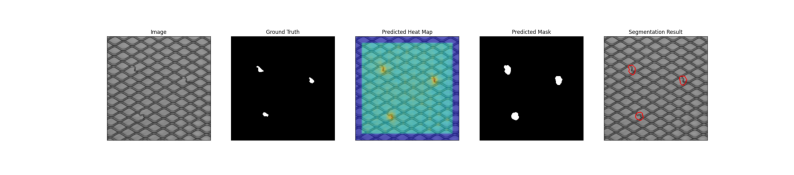

In [16]:
%matplotlib inline
img = Image.open(path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

##AUROC values


EfficientAd:
Average AUROC: 0.9443

PatchCore:
Average AUROC: 0.9882


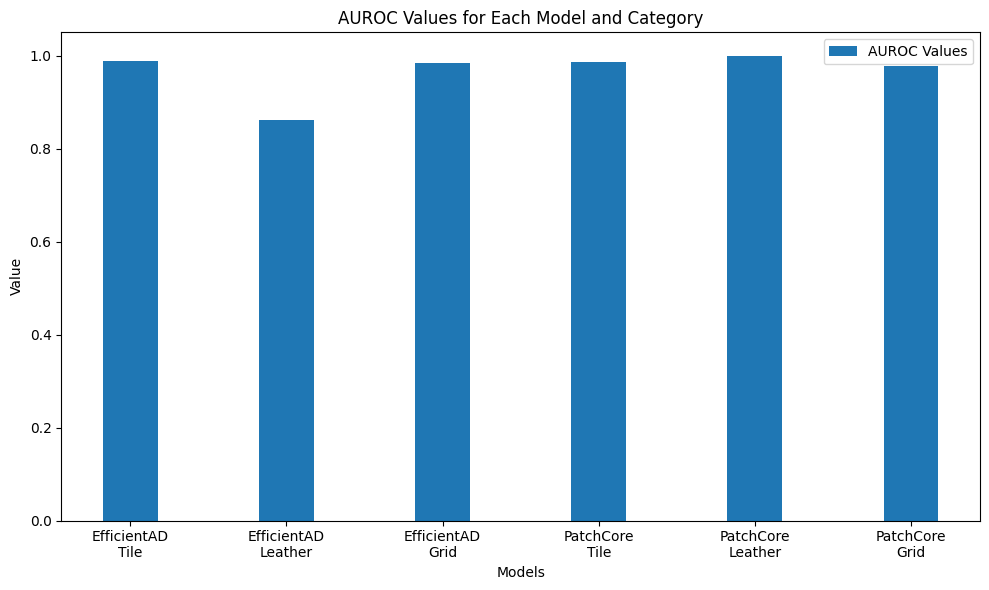

In [20]:
au_roc_values = []
au_roc_values.append(results['EfficientAd']['tile']['image_AUROC'])
au_roc_values.append(results['EfficientAd']['leather']['image_AUROC'])
au_roc_values.append(results['EfficientAd']['grid']['image_AUROC'])

au_roc_values.append(results['PatchCore']['tile']['image_AUROC'])
au_roc_values.append(results['PatchCore']['leather']['image_AUROC'])
au_roc_values.append(results['PatchCore']['grid']['image_AUROC'])

#Bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(au_roc_values))

plt.bar(index, au_roc_values, bar_width, label='AUROC Values')
plt.xlabel('Models')
plt.ylabel('Value')
plt.title('AUROC Values for Each Model and Category')
plt.xticks(index, ['EfficientAD\nTile', 'EfficientAD\nLeather', 'EfficientAD\nGrid', 'PatchCore\nTile', 'PatchCore\nLeather', 'PatchCore\nGrid'])
plt.legend()
plt.tight_layout()


for model in results:
    print(f"\n{model}:")

    scores = [results[model][cat]['image_AUROC'] for cat in results[model]]
    avg = np.mean(scores)
    print(f"Average AUROC: {avg:.4f}")

In [18]:
results

{'EfficientAd': {'tile': {'image_AUROC': 0.9884559512138367,
   'image_F1Score': 0.9707602262496948,
   'pixel_AUROC ': 0.8817263245582581,
   'pixel_F1Score': 0.6824756264686584},
  'leather': {'image_AUROC': 0.8603940606117249,
   'image_F1Score': 0.8681318759918213,
   'pixel_AUROC ': 0.9597247242927551,
   'pixel_F1Score': 0.5123558044433594},
  'grid': {'image_AUROC': 0.9841270446777344,
   'image_F1Score': 0.9821428656578064,
   'pixel_AUROC ': 0.9070193767547607,
   'pixel_F1Score': 0.4731081426143646}},
 'PatchCore': {'tile': {'image_AUROC': 0.9870129227638245,
   'image_F1Score': 0.9818181991577148,
   'pixel_AUROC ': 0.9479482769966125,
   'pixel_F1Score': 0.6201785206794739},
  'leather': {'image_AUROC': 1.0,
   'image_F1Score': 0.994535505771637,
   'pixel_AUROC ': 0.9899755120277405,
   'pixel_F1Score': 0.4420613944530487},
  'grid': {'image_AUROC': 0.9774436950683594,
   'image_F1Score': 0.9649122953414917,
   'pixel_AUROC ': 0.9801450967788696,
   'pixel_F1Score': 0.3798

##Top 5 similar images

In [25]:
def train_and_run_similarity(category='tile', model_class=EfficientAd):
    """Train model and run similarity analysis."""
    # Initialize and train model
    batch_size = 1 if model_class == EfficientAd else 32
    datamodule = MVTec(
        root="./datasets/MVTec",
        category=category,
        train_batch_size=batch_size
    )
    model = model_class()
    engine = Engine(max_epochs=5)

    print(f"Training {model_class.__name__} on {category}...")
    engine.fit(datamodule=datamodule, model=model)

    # Run similarity analysis
    print("\nRunning similarity analysis...")
    sim_search = AnomalySimSearch(model, category)
    sim_search.index_dataset(datamodule)

    # Get test samples
    test_loader = datamodule.test_dataloader()
    batch = next(iter(test_loader))

    # Handle different input formats
    if isinstance(batch, dict):
        images = batch['image']
    elif isinstance(batch, (tuple, list)):
        images = batch[0]
    else:
        images = batch

    # Get predictions
    model.eval()
    device = next(model.parameters()).device
    images = images.to(device)
    with torch.no_grad():
        predictions = model(images)

    # Show similar cases for top anomalous samples
    scores = predictions.cpu().numpy()
    top_indices = np.argsort(scores.flatten())[-3:]

    print("\nShowing similar cases for top anomalous samples:")
    for idx in top_indices:
        print(f"\nQuery image anomaly score: {scores.flatten()[idx]:.3f}")
        similar = sim_search.visualize_similar({'image': images[idx:idx+1]})

        print("Similar cases:")
        for i, hit in enumerate(similar, 1):
            print(f"Match {i}: Anomaly Score = {hit.payload['anomaly_score']:.3f}, "
                  f"Similarity = {hit.score:.3f}")


In [26]:
%matplotlib inline
train_and_run_similarity('tile', EfficientAd)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: 
  | Name                  | 

Training EfficientAd on tile...


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.10/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.



Running similarity analysis...
Indexing images for tile...


  0%|          | 0/4 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'device'